In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.timeseries import aggregate_downsample
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import LombScargle
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.utils.data import get_pkg_data_filename

In [3]:
filename = get_pkg_data_filename('/home/localadmin/1SWASPJ092751.85-040759.8.fits')
filename

'/home/localadmin/1SWASPJ092751.85-040759.8.fits'

In [4]:
t = Table.read(filename, hdu=1)

In [5]:
t['TMID'] = (t['TMID'] / 86400.0) + 2453005.5
t['TMID'].unit = 'day'
t['mag'] = 15.0 - (2.5 * np.log(t['FLUX2']))
t['mag'].unit = 'AB'
t['TAMFLUX2'].unit = 'mag'
t['TAMFLUX2_ERR'].unit = 'mag'
t['time'] = Time(t['TMID'], format='jd')
t.keep_columns(['time', 'TAMFLUX2', 'TAMFLUX2_ERR'])

In [6]:
ts = TimeSeries(t)

Text(0, 0.5, 'SAP Flux (e-/s)')

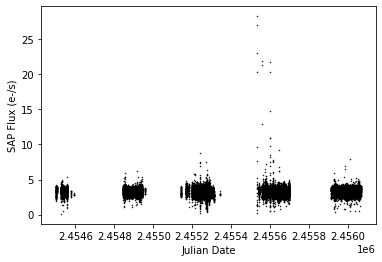

In [7]:
plt.plot(ts.time.jd, ts['TAMFLUX2'], 'k.', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

In [8]:
periodogram = LombScargle.from_timeseries(ts, signal_column_name='TAMFLUX2', uncertainty='TAMFLUX2_ERR', nterms=6)

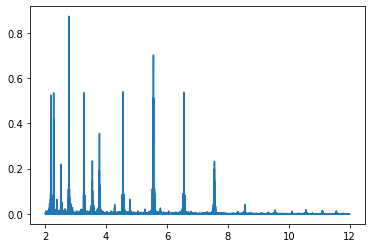

In [9]:
min_period = 2.0 * u.hour
max_period = 12.0 * u.hour

frequency, power = periodogram.autopower(
    nyquist_factor=5,
    minimum_frequency=1.0 / (max_period.to(u.day)),
    maximum_frequency=1.0 / (min_period.to(u.day)),
    samples_per_peak=10
)
#frequency=periodogram.autofrequency(nyquist_factor=1)
best = power.argmax()
#best = frequency.argmax()
period = 1.0 / frequency[best]

plt.plot(frequency, power)

In [18]:
sorted = power.argsort()[::-1]

for i in range(20):
    print((1 / frequency[sorted[i]]).to(u.hour))

8.644721539544374 h
8.644522309000466 h
8.644920779271837 h
4.3223380215746 h
4.322387830408188 h
4.322288213888939 h
4.322437640389742 h
4.322238407351164 h
8.644323087639478 h
4.322487451519301 h
8.645120028183491 h
5.274975088512431 h
3.6611862407946685 h
7.322333651839672 h
10.550017938189663 h
5.2749009064965335 h
3.661150505010479 h
10.98344223375274 h
5.275049272614831 h
3.661221977276485 h


In [24]:
def boundify(a, sigma=2.0):
    mean = a.mean()
    dev = np.std(a)
    
    return (mean - (sigma * dev)).value, (mean + (sigma * dev)).value

In [25]:
period = 1.0 / frequency[sorted[0]]
# period = 1.0 / frequency[power.argmax()]
ts_folded = ts.fold(period=period)
y_min, y_max = boundify(ts_folded['TAMFLUX2'])
period.to(u.hour)

<Quantity 8.64472154 h>

Text(0, 0.5, 'SAP Flux (e-/s)')

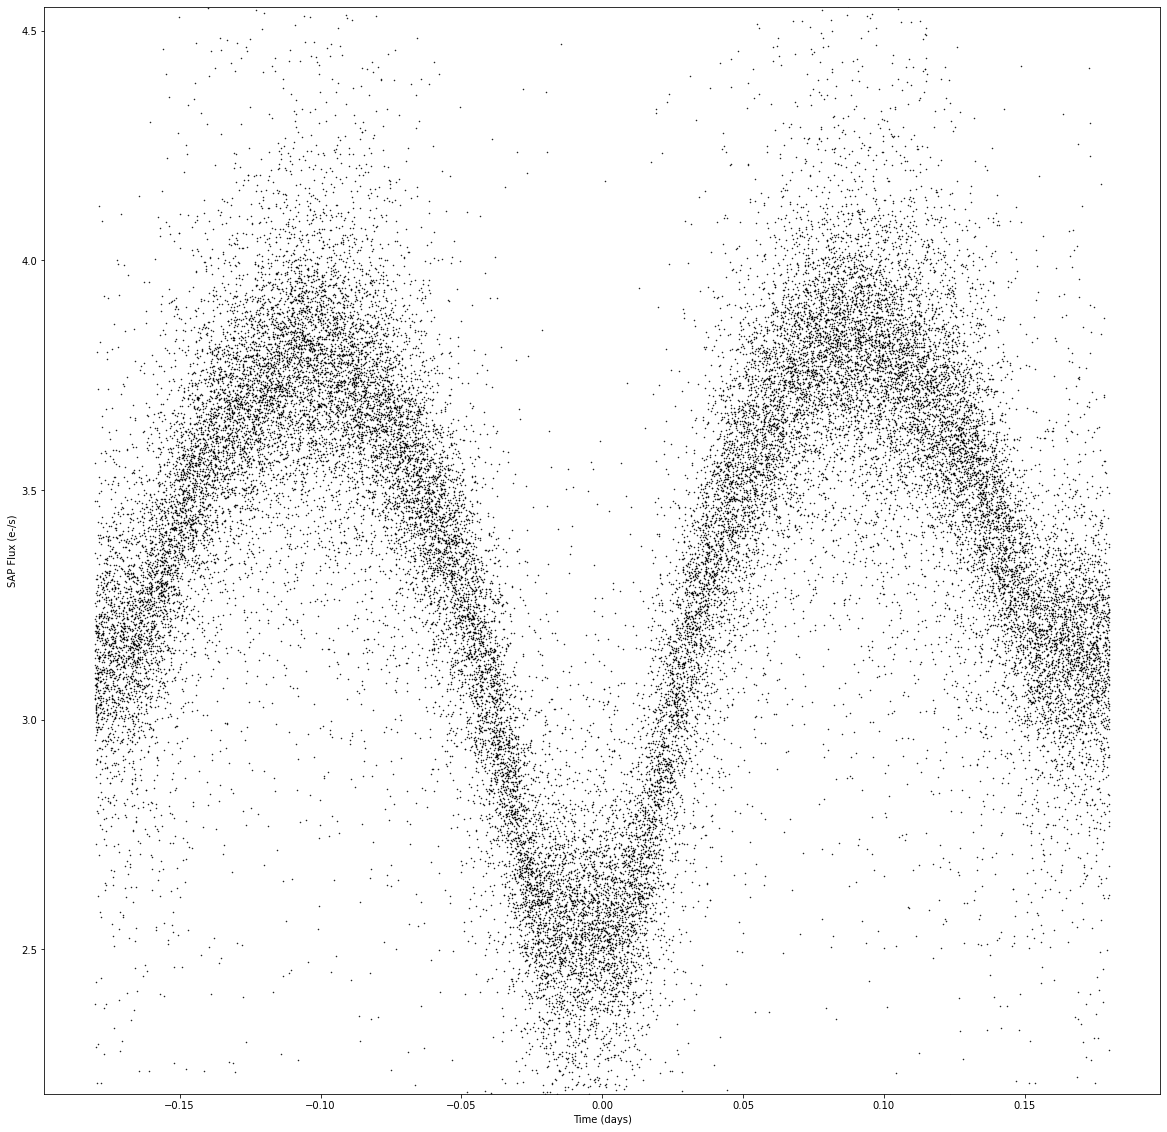

In [26]:
plt.figure(figsize=(20,20))
plt.plot(ts_folded.time.jd, ts_folded['TAMFLUX2'], 'k.', markersize=1)
plt.ylim(bottom=y_min, top=y_max)
plt.xlabel('Time (days)')
plt.ylabel('SAP Flux (e-/s)')

In [27]:
mean, median, stddev = sigma_clipped_stats(ts_folded['TAMFLUX2'])  
ts_folded['FLUX2_NORM'] = ts_folded['TAMFLUX2'] / median

ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.001 * u.day)  

Text(0, 0.5, 'Normalized flux')

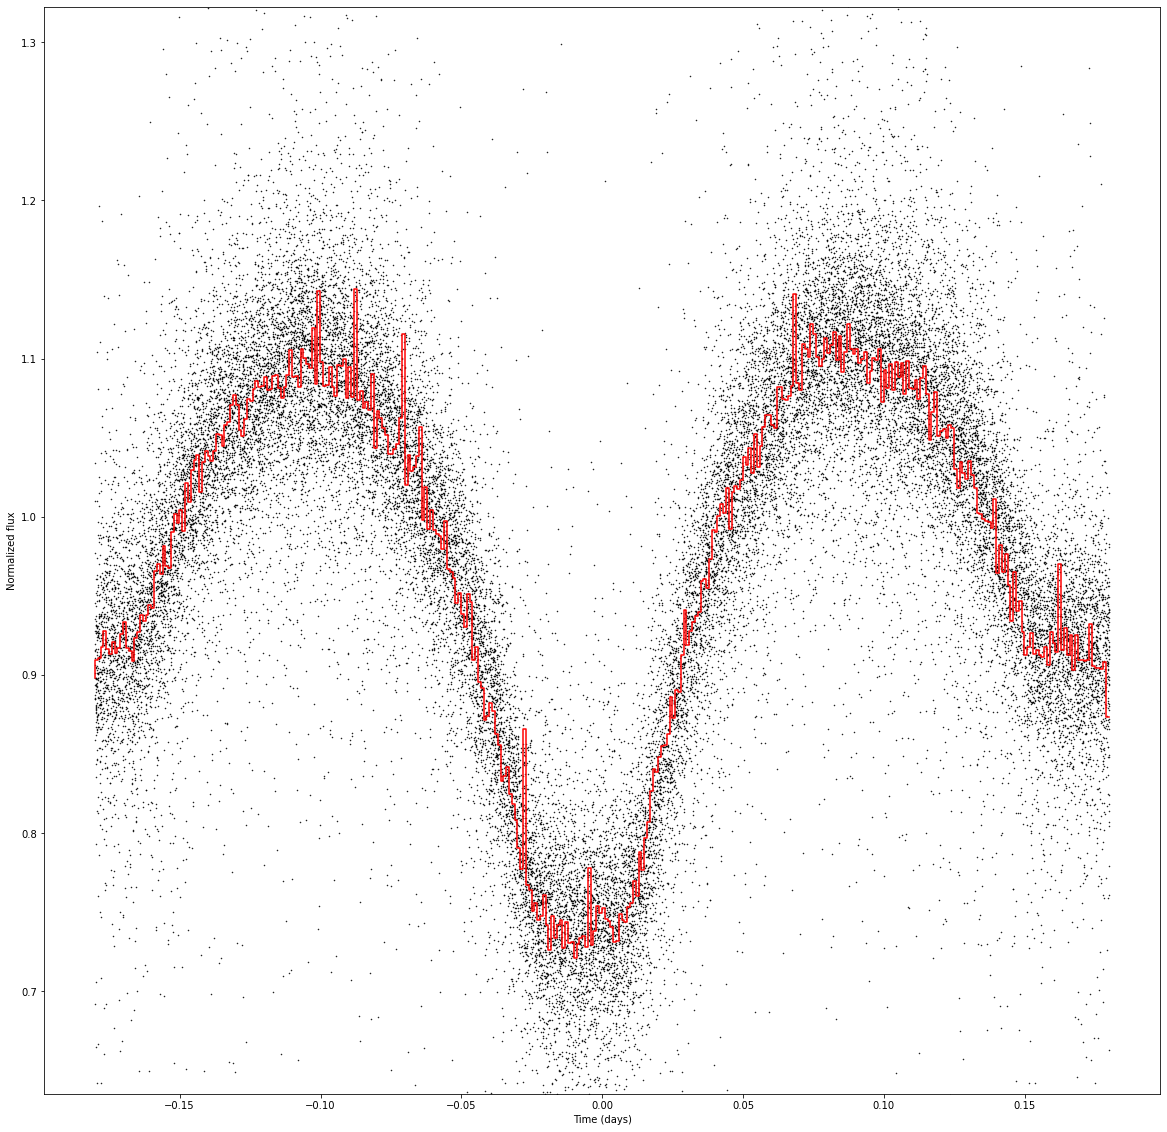

In [28]:
y_min, y_max = boundify(ts_folded['FLUX2_NORM'])

plt.figure(figsize=(20,20))
plt.plot(ts_folded.time.jd, ts_folded['FLUX2_NORM'], 'k.', markersize=1)
plt.plot(ts_binned.time_bin_start.jd, ts_binned['FLUX2_NORM'], 'r-', drawstyle='steps')
plt.ylim(bottom=y_min, top=y_max)
plt.xlabel('Time (days)')
plt.ylabel('Normalized flux')